In [1]:
import pandas as pd
import numpy as np
from netCDF4 import Dataset, num2date
import nctoolkit as nc
import matplotlib.pyplot as plt
from numpy.fft import fft, fftfreq, ifft

nctoolkit is using Climate Data Operators version 2.3.0


In [28]:
from plot_functions import data_manipulation
#data_path  = '/Users/charliecameron/CodingHub/Uni/Data_driven_processes/Data_modelling/data_sets/data_aus.nc'
data_path = '/Users/charliecameron/CodingHub/Uni/Data_driven_processes/Data_modelling/rainfall_software/DATA/data_alice_springs.nc'
#Now we can create an instance using the data_manipulation class
data_class = data_manipulation(data_path)


Plotting the bounds for the region

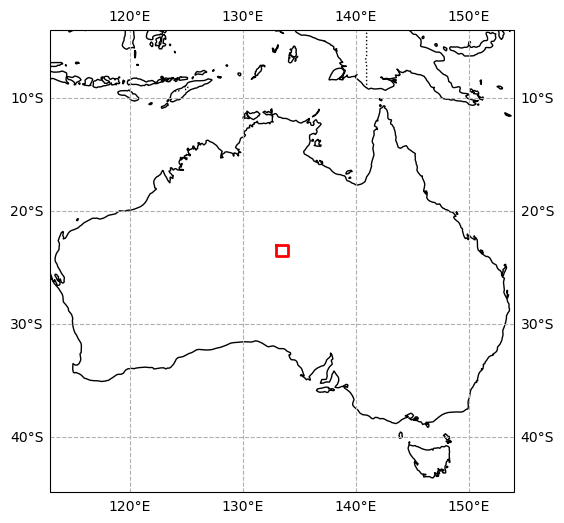

11354.459080823628

In [29]:
data_class.geo_plot()
data_class.metadata
data_class.area/1e6

We can also plot the rainfall data in this region for any index (which ranges in dates)

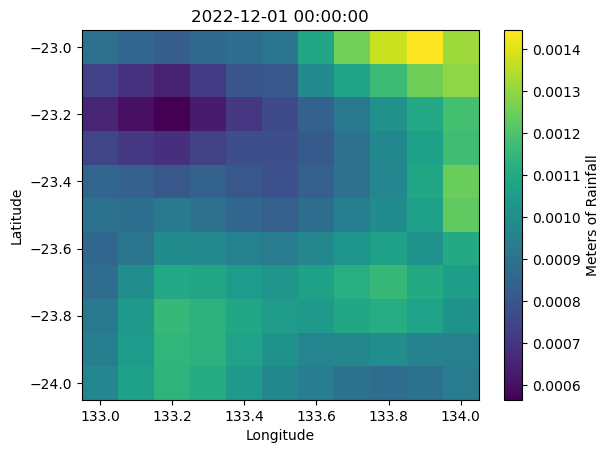

The rainfall data in this region for date: 2022-12-01 00:00:00


In [30]:
data_class.rain_plot(-1)

Extracting the metadata, this contains the years of recorded data and also the range of longitude and latitude values

In [31]:
data_class.metadata['lon'] #THis contains values for the latitude/longitude and the times in gregorian format and also month/year format

masked_array(data=[133. , 133.1, 133.2, 133.3, 133.4, 133.5, 133.6, 133.7,
                   133.8, 133.9, 134. ],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [32]:
data_class.metadata['lat'] 

masked_array(data=[-23. , -23.1, -23.2, -23.3, -23.4, -23.5, -23.6, -23.7,
                   -23.8, -23.9, -24. ],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [33]:
len(data_class.metadata['dates'])

876

For this data we have the Metres of rainfall that falls if spread uniformly over each grid point. Each grid point of Corpernicus data is $0.1 \degree \times 0.1 \degree$ in dimension.  

Note that for the Klausmeier model we are using $kg m^{-2} year^{-1}$ (so we must do some conversion). 

We can estimate the amount of rainfall in $kg$ that falls in each grid point area by converting the total water into litres $\rightarrow$ $kg$. 

The following in the total rainfall in $m^3$ that falls on the entire area.
$$
\text{Area} \times \text{Depth} = \text{Total water}(m^3)
$$
$$
\text{Total water}(m^3)*1000 = \text{Total Mass}(kg)
$$


Steps in data manipulation:
- Must workout total area in $m^2$ for each individual grid point. This will be very similar but will change depending on the latitude 
- Must calculate the total water in cubic metres that falls on the area
- This is then converted into $kg$ which then can be converted to $kgm^-2$

- Since we are using a small bounding box we could assume that the area per coordinate grid is equal. We could 

The class will also be able to store the total rainfall over the entire region and approximate the average rainfall per km^2

In [34]:
DFtotal,DFmean = data_class.GenerateTable()


Generates Two datasets: Total rainfall over timeframe, Averaged by Month


In [35]:
DFtotal.head(20)


,kg_m2,date,month_number,month
0,0.087556,1950-01,1,January
1,1.587241,1950-02,2,February
2,0.985675,1950-03,3,March
3,0.000936,1950-04,4,April
4,1.121671,1950-05,5,May
5,1.311347,1950-06,6,June
6,0.056094,1950-07,7,July
7,0.001147,1950-08,8,August
8,0.088138,1950-09,9,September
9,0.488738,1950-10,10,October


In [10]:
DFmean['Monthly_Mass_Rainfall'].mean()*12

9.195174375035544

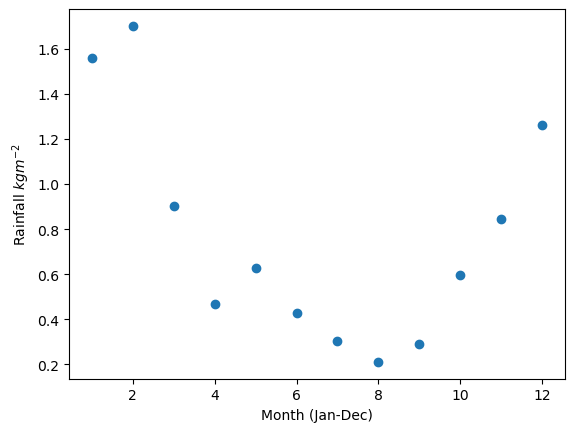

In [11]:
figure= plt.figure()
plt.plot(DFmean['Month_number'], DFmean['Monthly_Mass_Rainfall'],'o')
plt.xlabel('Month (Jan-Dec)')
plt.ylabel('Rainfall $kg m^{-2}$')
plt.show()

In [12]:
DFmean['Monthly_Mass_Rainfall']
#find sum of this
total = DFmean['Monthly_Mass_Rainfall'].sum()
#add the first, seocnd and last elements

sum1 = DFmean['Monthly_Mass_Rainfall'].iloc[5]+DFmean['Monthly_Mass_Rainfall'].iloc[6]+DFmean['Monthly_Mass_Rainfall'].iloc[7]
print(100*(sum1/total))


10.262181735679896


In [13]:
from fourier import fourier_analysis

kg_m2_data = DFtotal['kg_m2'].tolist()
m_data = DFtotal['month_number'].tolist()

In [14]:
Fourier = fourier_analysis(DFtotal['month_number'].tolist(),DFtotal['kg_m2'].tolist())

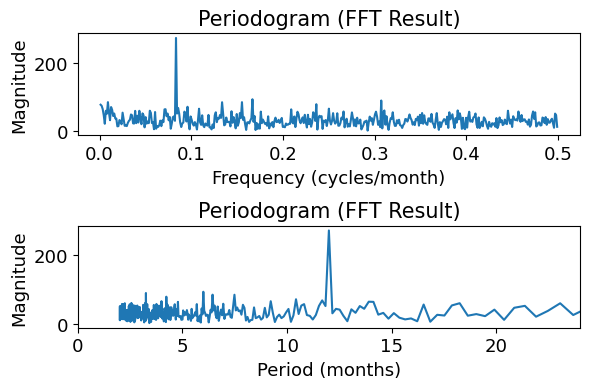

In [15]:
Amp,Freq,phase= Fourier.find_freq()
Fourier.plot_freq()

In [16]:
mn = np.array(DFmean['Month_number'].to_list())
ap = np.array(DFmean['Monthly_Mass_Rainfall'].to_list())

437


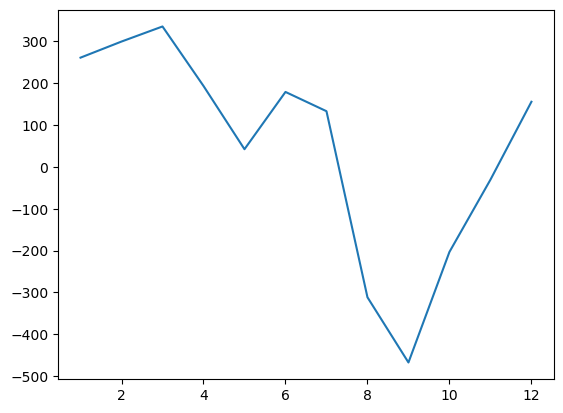

In [17]:
print(len(Amp))
y = np.zeros(len(mn))

for i in range(10):
    y += Amp[i]*np.sin(Freq[i]*2*np.pi*(mn+phase[i]))

plt.figure()
plt.plot(mn,y)

[0.38563834 0.48625248 0.1790867  0.11319089 0.76626453]
[[ 4.67823207e-03 -3.24881303e-12  2.05690741e-11 -3.57547076e-11
  -1.65007394e-11]
 [-3.24881303e-12  4.67823208e-03 -4.80751221e-11  2.31070309e-11
  -8.96873702e-12]
 [ 2.05690741e-11 -4.80751221e-11  4.67823205e-03 -1.01213649e-10
  -1.46751311e-11]
 [-3.57547076e-11  2.31070309e-11 -1.01213649e-10  4.67823206e-03
   5.40632032e-19]
 [-1.65007394e-11 -8.96873702e-12 -1.46751311e-11  5.40632032e-19
   2.33911600e-03]]


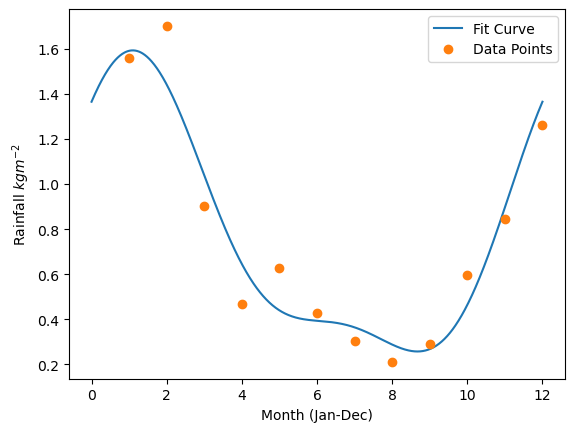

0.766264531252962

In [18]:
from scipy.optimize import curve_fit
#fit simple fourier series to data mn and ap (ap is y,mn is x)

x = np.linspace(0,12,1000)


def fit_curve(x,a1,a2,a3,a4,constant) :

    first_node = a1 * np.sin(2*np.pi*Freq[0] * x) + a2 * np.cos(2*np.pi*Freq[0] * x)  
    second_node = a3 * np.sin(2*np.pi*Freq[1] * x) + a4 * np.cos(2*np.pi*Freq[1] * x) 
    return  first_node + second_node +constant



popt, pcov = curve_fit(fit_curve, mn, ap)
print(popt)
print(pcov)
plt.figure()
plt.plot(x, fit_curve(x, *popt), label='Fit Curve')
plt.plot(mn, ap, 'o', label='Data Points')

# Add labels for the axes
plt.xlabel('Month (Jan-Dec)')
plt.ylabel('Rainfall $kg m^{-2}$')

# Add a legend
plt.legend()

plt.show()



ap.mean()



In [19]:
#Calculate from the data. 


#circumference is 203mm which is 0.203 metres 

B_area = np.pi*(0.203/2)**2
print(B_area) 

bucket_data = open('alice_springs.txt','r')

data = bucket_data.readlines()

print(type(data[0]))

data = [float(i) for line in data for i in line.split('\t')]

data_scaled = np.array(data)/(1000*B_area)

print(data_scaled)



0.03236547291544545
<class 'str'>
[1.31930716 1.2791409  1.02269477 0.50671282 0.49744368 0.451098
 0.42020087 0.32133008 0.29043296 0.62103217 0.77551779 1.12156557
 8.62956647]


<function matplotlib.pyplot.legend(*args, **kwargs) -> 'Legend'>

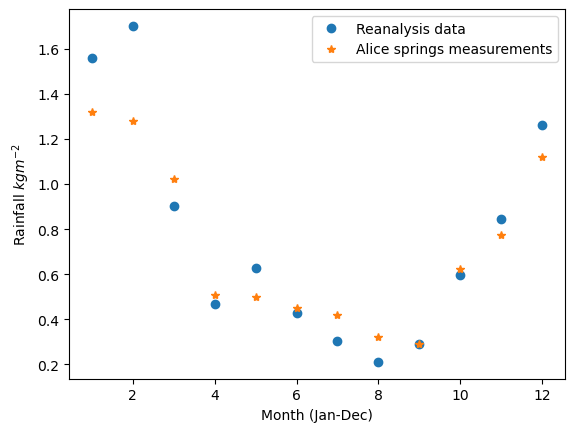

In [20]:
plt.figure()
plt.plot(mn,ap,'o',label='Reanalysis data')
plt.plot(mn,data_scaled[:-1],'*',label='Alice springs measurements')
plt.xlabel('Month (Jan-Dec)')
plt.ylabel('Rainfall $kg m^{-2}$')
plt.legend()
plt.legend

In [21]:
ap.min()/ap.mean()

0.27477120338390953

Checking that the rainfall is relatively consistent across the entire spatial domain. 

In [22]:
print(data_class.data)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    Conventions: CF-1.6
    history: 2024-03-14 13:38:45 GMT by grib_to_netcdf-2.24.0: /opt/ecmwf/eccodes/bin/grib_to_netcdf -S param -o /cache/tmp/b891c24d-3c34-41ca-af54-6fb9a4c64949-adaptor.mars.internal-1710423523.9292204-10533-19-tmp.nc /cache/tmp/b891c24d-3c34-41ca-af54-6fb9a4c64949-adaptor.mars.internal-1710422739.1005154-10533-17-tmp.grib
    dimensions(sizes): longitude(11), latitude(11), time(876)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 time(time), int16 tp(time, latitude, longitude)
    groups: 


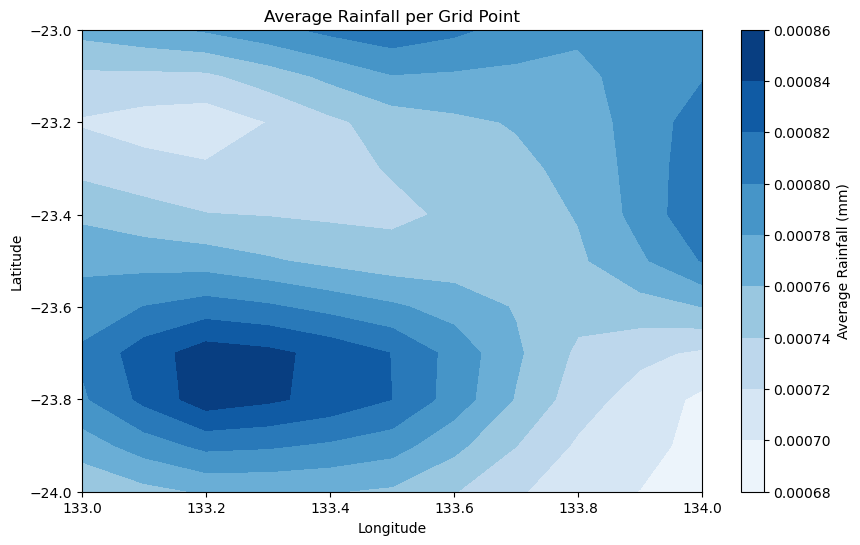

0.0007662645312529617

In [25]:
data_class.average_rainfall_per_grid()

mean_data = data_class.average_rainfall 


Finding if theres statisitcal significance with just a normally distributed data set! 

(876, 11, 11)
(876, 121)
[0.7624214644641765, 0.9765190855229062, 0.963005792519818, 0.9986065698767471, 0.996550703162992, 0.897705969669322, 0.9926763018910782, 0.9998810381143111, 0.9926763018910782, 0.9999974633201664, 1.0, 0.45035869283429525, 0.524528615672013, 0.603084059521272, 0.6432689282684735, 0.8681545952331096, 0.9453767803227344, 0.996550703162992, 0.9986065698767471, 0.9998810381143111, 0.9995374410235364, 0.996550703162992, 0.2927165049317373, 0.35057262262922806, 0.2664587767101268, 0.320753613649448, 0.45035869283429525, 0.723433203742274, 0.8353786157734827, 0.9765190855229062, 0.963005792519818, 0.9765190855229062, 0.8353786157734827, 0.4867774452519203, 0.3821521935115847, 0.35057262262922806, 0.524528615672013, 0.603084059521272, 0.603084059521272, 0.723433203742274, 0.8353786157734827, 0.9453767803227344, 0.9765190855229062, 0.7624214644641765, 0.6835409439482546, 0.603084059521272, 0.4867774452519203, 0.563390474606386, 0.723433203742274, 0.603084059521272, 0.6

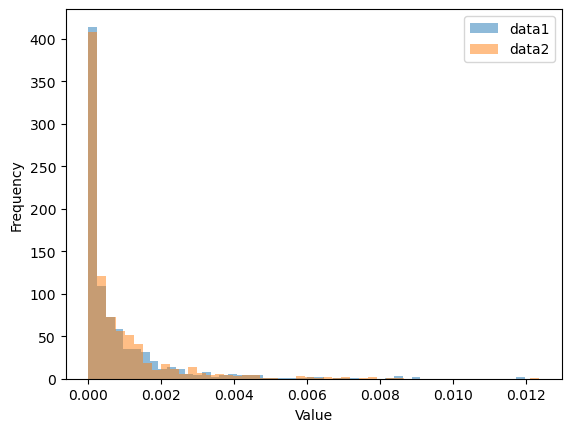

0.013859252445399761


In [89]:
import scipy.stats as stats 

rainfall_data = data_class.data.variables['tp'][:]
print(rainfall_data.shape)


list_data = rainfall_data.reshape(rainfall_data.shape[0],rainfall_data.shape[1]*rainfall_data.shape[2])

print(list_data.shape)


# list_data = np.zeros((rainfall_data.shape[0],rainfall_data.shape[1]**2))
#then list_data[:,k] will be a list of data for that location over time  
# for i in range(rainfall_data.shape[1]):
#     for j in range(rainfall_data.shape[2]):
#         list_data[:,i+j] = rainfall_data[:,i,j]

reference_set = list_data[:,50]
p_values = []
for i in range(list_data.shape[1]):
    _, p_value = stats.ks_2samp(list_data[:,i], list_data[:,10])
    p_values.append(p_value)

print(p_values)

plt.hist(list_data[:,5], bins=50, alpha=0.5, label='data1')
plt.hist(list_data[:,100], bins=50, alpha=0.5, label='data2')

# Add labels and legend
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

plt.show()
max_value = 0
for i in range(list_data.shape[1]):
    new_max = np.max(list_data[:,i])
    if new_max >= max_value:
        max_value = new_max
print(max_value)


KS p-value between histograms: 0.8079631540901643


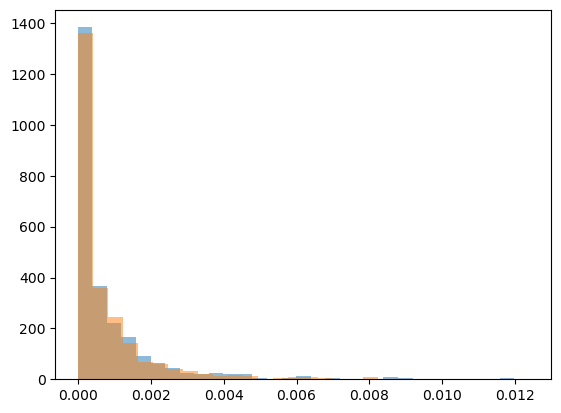

In [88]:
bin_size = round(np.sqrt(876))
hist_1, _ = np.histogram(list_data[:, 5], bins=bin_size, density=True)
hist_2, _ = np.histogram(list_data[:, 100], bins=bin_size, density=True)

_, p_value_hist = stats.ks_2samp(hist_1, hist_2)

print("KS p-value between histograms:", p_value_hist)

#plot the histograms
plt.figure()
plt.hist(list_data[:,5], bins = bin_size, alpha=0.5, label='data1',density=True)
plt.hist(list_data[:,100], bins=bin_size, alpha=0.5, label='data2',density=True)

plt.show()



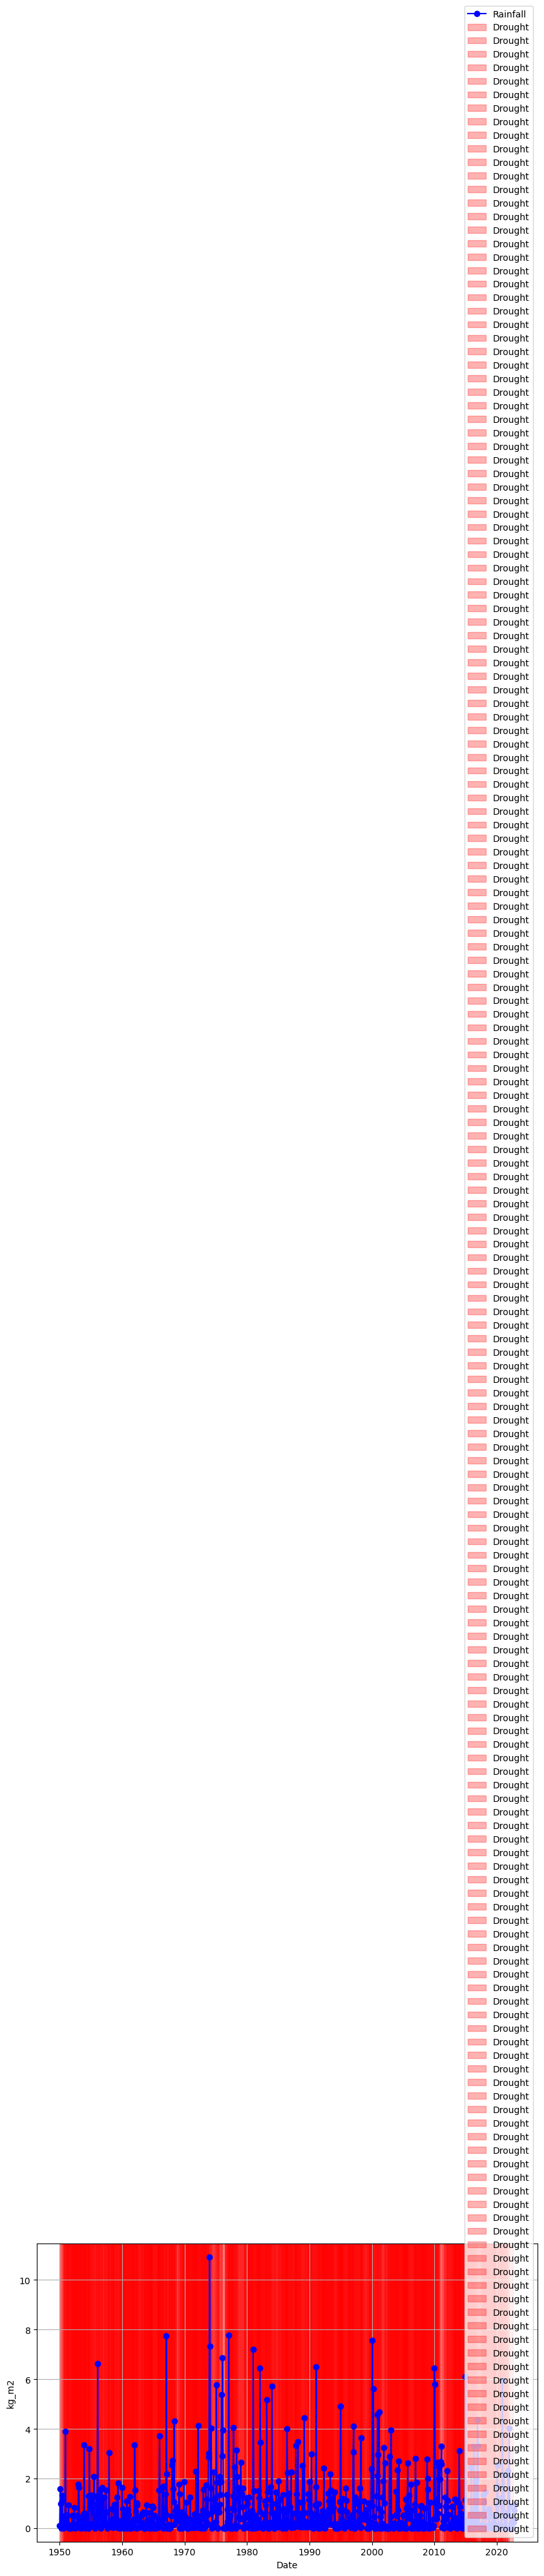

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming DFtotal contains your DataFrame with 'date', 'kg_m2', and 'month' columns

# Convert 'date' column to datetime
DFtotal['date'] = pd.to_datetime(DFtotal['date'])

# Calculate monthly average rainfall
monthly_avg = DFtotal.groupby('month')['kg_m2'].mean()

# Plot the data
plt.figure(figsize=(10, 6))

# Plot all data points
plt.plot(DFtotal['date'], DFtotal['kg_m2'], marker='o', color='blue', label='Rainfall')

# Iterate through each month
for month, avg in monthly_avg.items():
    drought_periods = []  # List to store drought periods
    is_drought = False
    start_date = None
    
    # Iterate through each row in DFtotal
    for index, row in DFtotal.iterrows():
        if row['month'] == month:
            if row['kg_m2'] < avg:
                if not is_drought:
                    start_date = row['date']
                    is_drought = True
            else:
                if is_drought:
                    drought_periods.append((start_date, row['date']))
                    is_drought = False
    
    # Shade drought periods
    for start, end in drought_periods:
        plt.axvspan(start, end, color='red', alpha=0.3, label='Drought')

plt.xlabel('Date')
plt.ylabel('kg_m2')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming DFtotal contains your DataFrame with 'date' and 'kg_m2' columns

# Convert 'date' column to datetime
DFtotal['date'] = pd.to_datetime(DFtotal['date'])

# Calculate monthly average
monthly_avg = DFtotal.groupby(DFtotal['date'].dt.to_period('M'))['kg_m2'].mean()

# Plot the data
plt.figure(figsize=(10, 6))

# Iterate through each data point
for date, kg_m2 in zip(DFtotal['date'], DFtotal['kg_m2']):
    # If the point is below the monthly average
    if kg_m2 < monthly_avg.loc[date.to_period('M')]:  
        plt.plot(date, kg_m2, marker='o', color='red')  # Plot in red
    else:
        plt.plot(date, kg_m2, marker='o', color='blue')  # Plot in blue

plt.xlabel('Date')
plt.ylabel('kg_m2')
plt.grid(True)
plt.show()

In [25]:
import matplotlib.pyplot as plt

# Ensure that 'date' is a datetime object
DFtotal['date'] = pd.to_datetime(DFtotal['date'])

# Set 'date' as the index
DFtotal.set_index('date', inplace=True)

# Plot 'kg_m2' over time
DFtotal['kg_m2'].plot()

# Increase the font size of the labels
plt.xlabel('Date', fontsize=16)
plt.ylabel('Rainfall (kg/m2)', fontsize=16)

# Increase the size of the ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Show the grid
plt.grid(True)

# Show the plot
plt.show()

KeyError: 'date'